<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab2_Capacitors/blob/main/Lab2_Capacitor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2. Capacitor experiment
Moodle: https://moodle2222.technion.ac.il/mod/resource/view.php?id=1119329

[.pdf manual](https://moodle2222.technion.ac.il/pluginfile.php/1816957/mod_resource/content/2/%D7%AA%D7%93%D7%A8%D7%99%D7%9A%20%D7%A7%D7%91%D7%9C%20%D7%90%D7%91%D7%99%D7%91%202022.pdf)

Evgeny Kolonsky, Feb 2023

## Setup
1. Capacitor experiment kit:
  - Aluminium disks 260mm x2 on plate, dielectric sheet
  - Aluminium disks 180mm x2 on plate, dielectric sheet
  - dock board
  - banana wires short-length, x2
2. Wires:
  - coaxial-banana, x1 
  - coaxial, x3  
3. Measurement equipment:
  - Scope Keysight
  - LCR 
  - Caliper


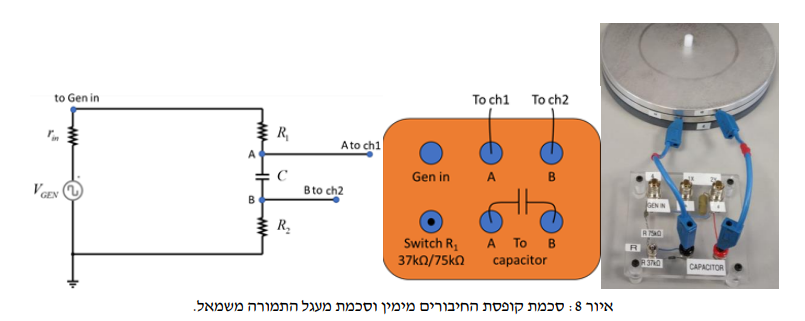

In [1]:
!pip install quantiphy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.7 MB/s eta 0:00:00


In [153]:
import numpy as np # math functions
import scipy # scientific functions
import matplotlib.pyplot as plt # for plotting figures and setting their properties
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import pandas as pd # handling data structures (loaded from files)
from scipy.stats import linregress # contains linregress (for linear regression)
from scipy.optimize import curve_fit as cfit # non-linear curve fitting
from sklearn.metrics import r2_score # import function that calculates R^2 score
import json, requests
import pandas as pd

from quantiphy import Quantity



In [154]:
def q_Farad(x):
  return str(Quantity(x,'F'))

## C12

Measure Resistance

In [ ]:
Rin = 50 # Ohm
R2 = 990 #Ohm - to measure (coax cabel -> banana)
R1 = 37.8e3 # measure as R on GEN with points A and B connected 
R1 = 75.75e3

R = Rin + R1 + R2

### 1. Build the plate capacitor with the largest possible capacitance in the system, without using the dielectric material.
Calculate its capacitance from the formula.

$$ C = {A \varepsilon_0 \varepsilon_r \over d}$$ 

## The first setup with big aluminium disks

In [ ]:
# theoretical value (side1, side2)
eps0 = 8.85e-12 #F/m
epsr = 1
diam1 = 260e-3 #m 
A1 = np.pi*diam1*diam1/4 #m2
diam2 = 180e-3 #m 
A2 = np.pi*diam2*diam2/4 #m2
d1 = 1.0e-3 #m
d2 = 0.8e-3 
C11_theor = A1* eps0/d1
C12_theor = A1* eps0/d2
C21_theor = A2* eps0/d1
C22_theor = A2* eps0/d2
print(Quantity(C11_theor, 'F'))
print(Quantity(C12_theor, 'F'))
print(Quantity(C21_theor, 'F'))
print(Quantity(C22_theor, 'F'))

469.87 pF
587.34 pF
225.21 pF
281.51 pF


In [ ]:
eps0 = 8.85e-12 #F/m
epsr = 1
diam = 260e-3 #m 
A = np.pi*diam*diam/4 #m2
d1 = (0.5 +0.69+.6)/3*1e-3 #m
d2 = (1.28 + 1.08 + 1.24 + 1.1 + 1.0 +1.2) /6 *1e-3 
C1_calc = A* eps0/d1
print(Quantity(C1_calc, 'F'))

Make square impuls: freq 500Hz, Vpp =5V, Offset = 2.5V. Catch discharge on the scope.


### 4. Method A. Direct capacitance $C$ measurement

In [ ]:
C1_meas_LRC = 0.261e-9 #F
print(Quantity(C1_meas_LRC, 'F'))

261 pF


### 4. Method B. Capacitance $C$ calculation

$$Q = C V$$

In [ ]:
data = pd.read_csv('Trace 0.csv')
PROBE1 = 10
PROBE2 = 10

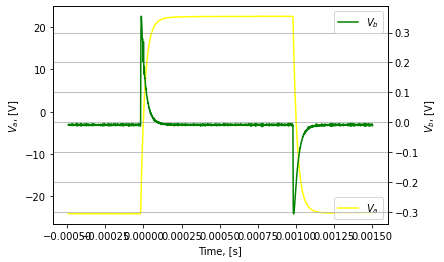

In [ ]:
time = np.array(data['Time'])
v1 = np.array(data['V1'])
v2 = np.array(data['V2'])


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_xlabel('Time, [s]')
ax1.set_ylabel('$V_a$, [V]')
ax2.set_ylabel('$V_b$, [V]')

ax1.plot(time, v1, color='yellow', label='$V_a$')
ax2.plot(time, v2, color='green', label='$V_b$')

plt.grid()
ax1.legend(loc='lower right')
ax2.legend(loc='upper right')
plt.show()



In [ ]:
inds = (v1 > 0.01) * (time < 0.0009) 
time = time[inds]
v1 = v1 [inds] / PROBE1
v2 = v2[inds]  / PROBE2

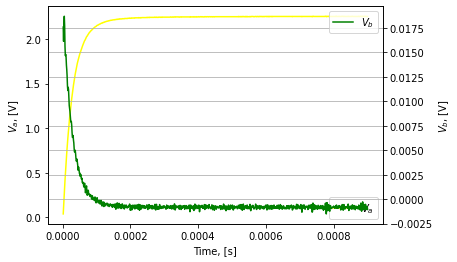

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_xlabel('Time, [s]')
ax1.set_ylabel('$V_a$, [V]')
ax2.set_ylabel('$V_b$, [V]')

ax1.plot(time, v1, color='yellow', label='$V_a$')
ax2.plot(time, v2, color='green', label='$V_b$')

plt.grid()
ax1.legend(loc='lower right')
ax2.legend(loc='upper right')
plt.show()



$$ Q = \int_0^t I(t) dt$$

In [ ]:
V_c = v1 - v2
I_c = v2/R2

Q_c = scipy.integrate.cumtrapz(I_c, x=time, initial=0)

fit = linregress(V_c, Q_c)
C1_meas_QcV = fit.slope
print('C by QcV method:{} '.format(Quantity(C1_meas_QcV,'F')))
print('C by LRC meas:  {} '.format(Quantity(C1_meas_LRC,'F')))


C by QcV method:-92.541 pF 
C by LRC meas:  261 pF 


In [ ]:
plt.plot(V_c, Q_c, label='Charge calculated')
plt.plot(V_c, C1_meas_QcV*V_c + fit.intercept, label='Linreg')
plt.grid()
plt.legend()
plt.xlabel('Voltage, [V]')
plt.ylabel('Charge, [C]')

### 6. Decay time $\tau$ calculation

$$ \tau = R C$$



#### 6א

In [ ]:
plt.plot(time, np.log(V_c))
plt.grid()
plt.legend()
plt.ylabel('Voltage, [V]')
plt.xlabel('Time, [s]')

Stripping non-linear right part of data, where $t>0.00115 s$.

In [ ]:
inds = time < 0.00115
time = time[inds]
V_c = V_c[inds]

In [ ]:
fit = linregress(time, np.log(V_c))
beta = fit.slope
tau_fit = -1/beta
C1_tau = tau_fit/R
plt.plot(time, np.log(V_c), label='Measurements')
plt.plot(time, time*beta + fit.intercept, label='Linreg')

plt.grid()
plt.legend()
plt.ylabel('Voltage, [V]')
plt.xlabel('Time, [s]')

In [ ]:

print('C by QcV method:{} '.format(Quantity(C1_meas_QcV,'F')))
print('C by LRC meas:  {} '.format(Quantity(C1_meas_LRC,'F')))
print('C by tau :      {} '.format(Quantity(C1_tau,'F')))
print('C by geometry:  {} '.format(Quantity(C1_calc,'F')))



## The second setup with small aluminium disks

In [ ]:
diam = 180e-3 #m 
A = np.pi*diam*diam/4 #m2
d1 = (.7 + .8 + .8)/3*1e-3 #m #yellow
d2 = (1.0 + 1.0 + 1.0) /3 *1e-3 # coral 
#d2 = (.95 + 1.0 + 1.0) /3 *1e-3 # coral - Idan measurements 
d1, d2

### 2.1 Yellow side down, $d=d_1$

In [ ]:
A = np.pi*diam*diam/4 #m2
C21_calc = A* eps0/d1
print('C21_calc:  {} '.format(Quantity(C21_calc ,'F')))


Direct measurement with LCR

In [ ]:
C21_meas_LCR = .347e-9 #F
print('C21_meas_LCR:  {} '.format(Quantity(C21_meas_LCR ,'F')))

In [ ]:
data = pd.read_csv('Trace_21.csv')

time = np.array(data['Time'])
v1 = np.array(data['V1'])
v2 = np.array(data['V2'])


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_xlabel('Time, [s]')
ax1.set_ylabel('$V_a$, [V]')
ax2.set_ylabel('$V_b$, [V]')

ax1.plot(time, v1, color='yellow', label='$V_a$')
ax2.plot(time, v2, color='green', label='$V_b$')

plt.grid()
ax1.legend()
ax2.legend()
plt.show()


### 2.2 Coral side down, $d=d_2$

Geometrical calculation

In [ ]:
C22_calc = A* eps0/d2
print('C22_calc:  {} '.format(Quantity(C22_calc ,'F')))

Direct LCR measurement

In [ ]:
C22_meas_LCR = .261e-9 #F
print('C22_meas_LCR:  {} '.format(Quantity(C22_meas_LCR ,'F')))

Decay time  

In [ ]:
data = pd.read_csv('Trace_22.csv')

time = np.array(data['Time'])
v1 = np.array(data['V1'])
v2 = np.array(data['V2'])


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_xlabel('Time, [s]')
ax1.set_ylabel('$V_a$, [V]')
ax2.set_ylabel('$V_b$, [V]')

ax1.plot(time, v1, color='yellow', label='$V_a$')
ax2.plot(time, v2, color='green', label='$V_b$')

plt.grid()
ax1.legend()
ax2.legend()
plt.show()

## 10. Small disks with dielectric

In [ ]:
d = 1-e3 #m - dielectric thickness

We do not know $\varepsilon_r$, so we have to calculate it later using capacitance measurements.

In [ ]:
C23_LCR = .579e-9 #F

eps_r = C23_LCR / C22_meas_LCR
eps_r

# Reproduce calcs with github-stored data

In [219]:
class Board:
  url = ''
  num = ''
  option = ''
  R_in = 50 # Ohm
  R1 = 0
  R2 = 0
  R = 0

  def __init__(self, num, option='1', url='https://raw.githubusercontent.com/evgeny-kolonsky/Lab2_Capacitors/main/'):
    self.url = url + 'Boards.csv'
    self.num = num
    self.option = option
    df = pd.read_csv(self.url)
    row = df[(df.Set == self.num) & (df.Option == option)]
    self.R1 = row.R1.tolist()[0]
    self.R2 = row.R2.tolist()[0]
    self.R = self.R_in + self.R1 + self.R2

class Capacitor:
  url = ''
  num = ''
  size = 0
  side = ''
  square = 0
  d = np.array([0,0,0])
  C_calculated = 0
  C_measured = 0

  def __init__(self, num, size=260, side='A', url='https://raw.githubusercontent.com/evgeny-kolonsky/Lab2_Capacitors/main/'):
    eps0 = scipy.constants.epsilon_0
    self.num = num
    self.size = size
    self.side = side
    diam = float(self.size) *1e-3 # mm->m
    self.square = np.pi*diam*diam/4
    self.url = url + 'Disks.csv'
    df = pd.read_csv(self.url)
    row = df[(df.Set == num) & (df.Diam==size) & (df.Side==side)]
    d1, d2, d3 = row.d1.tolist()[0], row.d2.tolist()[0], row.d3.tolist()[0]
    self.d = np.array([d1, d2, d3]) *1e-3 # mm -> m
    self.C_calculated = self.square/np.mean(self.d) * eps0
    self.C_measured = row.C_measured.tolist()[0] *1e-12 ## pF -> F 

class Experiment:
  num = ''
  trace_num = 0
  fname = ''
  url = ''
  board = ''
  capacitor = ''
  data = ''
  Vx = ''
  Vy = ''
  time = ''
  Q = ''
  I = ''
  C_Q = 0
  C_tau = 0
  filter = ''

  def reset_filter(self):
    self.filter = np.full(self.time.shape, True)
    return

  def cut_Vx(self, low, high):
    self.filter = self.filter * (self.Vx > low) * (self.Vx < high)
    return

  def cut_t(self, low, high):
    self.filter = self.filter * (self.time < high) * (self.time > low)
    return

  def __init__(self, num, trace_num=0,
               url='https://raw.githubusercontent.com/evgeny-kolonsky/Lab2_Capacitors/main/'):
    self.num = num
    self.trace_num = trace_num
    print('Read from Experiments table..')
    self.url = url + 'Experiments.csv'
    df = pd.read_csv(self.url)
    row = df[(df.Set == num) & (df.Trace==trace_num)]
    self.size = row.Size.tolist()[0]
    self.side = row.Side.tolist()[0]
    self.option = row.Option.tolist()[0]
    print(f'Set {num}, Trace {trace_num}, Size {self.size} Side {self.side} Option {self.option}')
    print(f'Read from Board table: Set {num}, {self.option}')
    self.board = Board(num, self.option, url)
    print(f'R1 = {self.board.R1}')
    print(f'Read from Disks table: Set {num}, {self.size} {self.side}')
    self.capacitor = Capacitor(num, self.size, self.side, url)
    print(f'Capacitance measured {q_Farad(self.capacitor.C_measured)}')
    self.fname = f'{url}{num}/Trace%20{trace_num}.csv'
    self.data  = pd.read_csv(self.fname, header=1)
    columns = 'Time (s),1 (VOLT),2 (VOLT)'.split(sep=',')
    self.time = np.array(self.data[columns[0]])
    self.Vx = np.array(self.data[columns[1]])
    self.Vy = np.array(self.data[columns[2]])
    self.reset_filter()
    return

  
  def get_filtered_data(self):
    vx = self.Vx[self.filter]
    vy = self.Vy[self.filter]
    t  = self.time[self.filter]
    return t, vx, vy


  def Calculate_Q(self, show=True):
    # Q - method
    t, vx, vy = self.get_filtered_data()
    V_c = vx - vy
    I_c = vy / self.board.R2
    Q_c = scipy.integrate.cumtrapz(I_c, x=t, initial=0)
    self.Q = Q_c
    fit = linregress(V_c, Q_c)
    self.C_Q = fit.slope
    if show:
      s = str(Quantity(self.C_Q, 'F'))
      plt.plot(V_c, Q_c, label='Charge calculated')
      plt.plot(V_c,fit.slope*V_c + fit.intercept, label=f'Linreg $C={s}$')
      plt.grid()
      plt.legend()
      plt.xlabel('Voltage, [V]')
      plt.ylabel('Charge, [C]')
    return

  def Calculate_tau(self, show=True):
    t, vx, vy = self.get_filtered_data()
    V_c = vx - vy
    fit = linregress(t, np.log(V_c))
    beta = fit.slope
    tau_fit = -1/beta
    self.C_tau = tau_fit/self.board.R
    if show:
      plt.plot(t, np.log(V_c), label='Measurements')
      s = Quantity(self.C_tau, 'F')
      plt.plot(t, t*beta + fit.intercept, label=f'Linreg $C$={s}')

      plt.grid()
      plt.legend()
      plt.ylabel('Voltage, [V]')
      plt.xlabel('Time, [s]')
    return

  def plot_V(self):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.set_xlabel('Time, [s]')
    ax1.set_ylabel('$V_x$, [V]')
    ax2.set_ylabel('$V_y$, [V]')

    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    t, vx, vy = self.get_filtered_data()

    ax1.plot(t, vx, color='yellow', marker='.', label='$V_a$')
    ax2.plot(t, vy, color='green', label='$V_b$')

    plt.grid()
    ax1.legend()
    ax2.legend()
    plt.show()
    return

  def print(self):
    print(f'Experiment parameters: Set {self.num}, trace {self.trace_num}, Size {self.size}, Side {self.side}, {self.option}')
    print('Calculated    :'+ q_Farad(ex.capacitor.C_calculated))
    print('Direct measure:'+ q_Farad(ex.capacitor.C_measured))
    print('Measure by Q  :'+ q_Farad(ex.C_Q))
    print('Measure by tau:'+ q_Farad(ex.C_tau))    




Read from Experiments table..
Set C01, Trace 0, Size 260 Side A Option R37
Read from Board table: Set C01, R37
R1 = 37600.0
Read from Disks table: Set C01, 260 A
Capacitance measured 427 pF


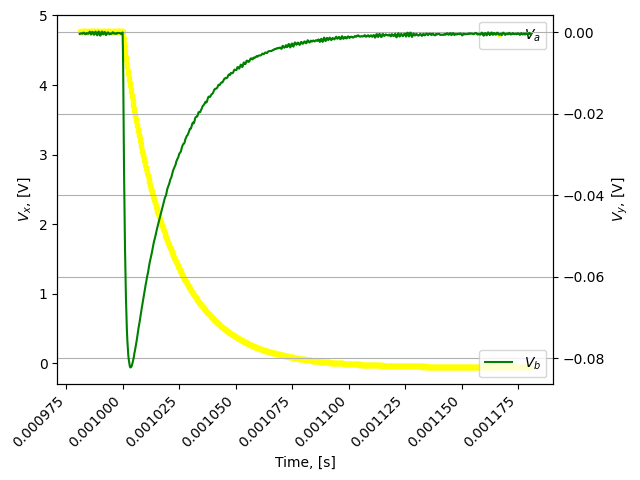

In [220]:
ex = Experiment('C01', trace_num=0)
ex.plot_V()

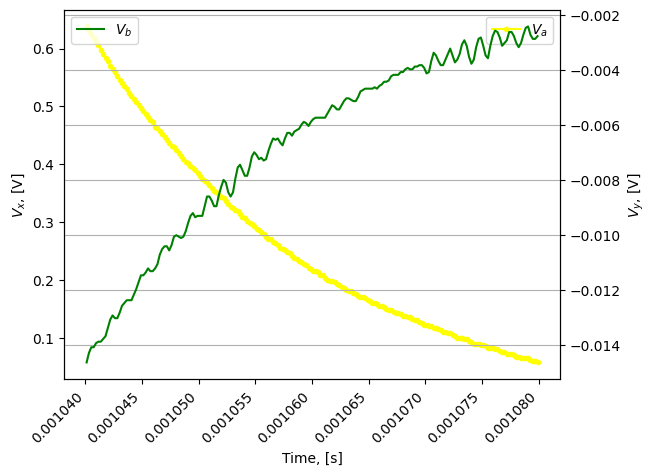

In [221]:
ex.reset_filter()
ex.cut_t(0.00104, 0.00108)
ex.cut_Vx(0, 0.7)
ex.plot_V()

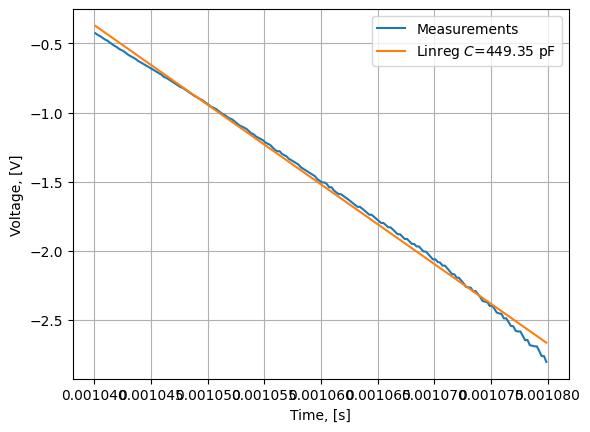

In [222]:
ex.Calculate_tau()

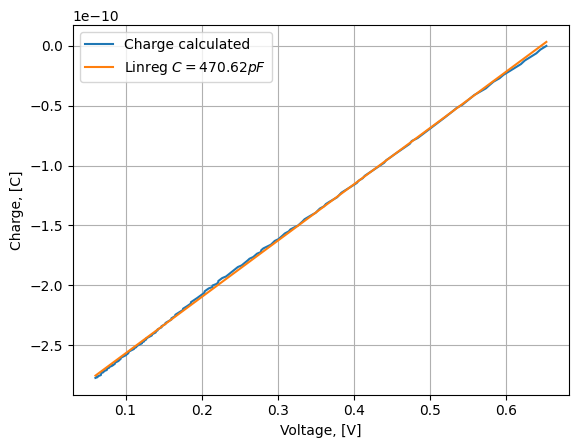

In [223]:
ex.Calculate_Q()

In [224]:
ex.print()

Experiment parameters: Set C01, trace 0, Size 260, Side A, R37
Calculated    :428.66 pF
Direct measure:427 pF
Measure by Q  :470.62 pF
Measure by tau:449.35 pF


Read from Experiments table..
Set C01, Trace 1, Size 260 Side B Option R37
Read from Board table: Set C01, R37
R1 = 37600.0
Read from Disks table: Set C01, 260 B
Capacitance measured 586 pF


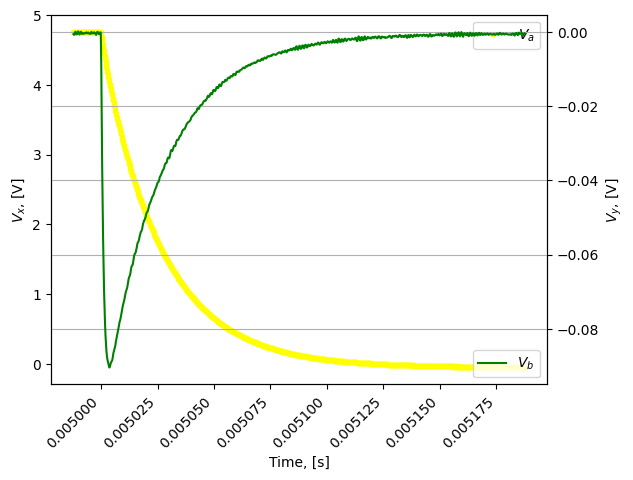

In [225]:
ex = Experiment('C01', trace_num=1)
ex.plot_V()

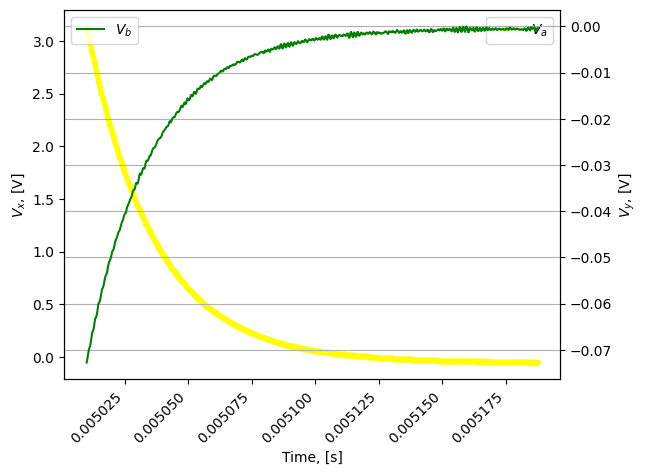

In [227]:
ex.reset_filter()
ex.cut_t(0.00501, 1)
ex.plot_V()

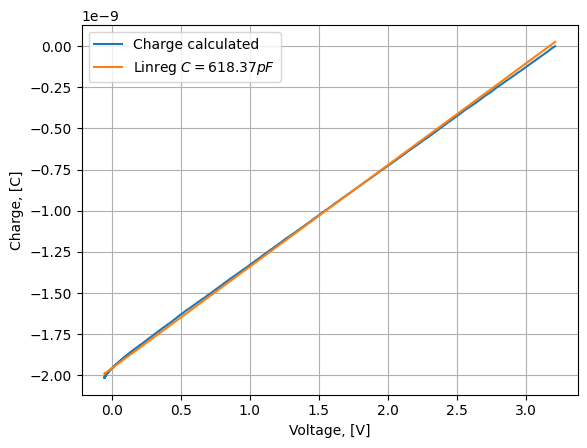

In [229]:
ex.Calculate_Q()

In [230]:
ex.print()

Experiment parameters: Set C01, trace 1, Size 260, Side B, R37
Calculated    :592.56 pF
Direct measure:586 pF
Measure by Q  :618.37 pF
Measure by tau:0 F
